[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/box.ipynb)  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/deJong_Azimi/box.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Azimi/box.ipynb)

In [ ]:
from typing import Optional

from scipy.special import gamma
from matplotlib import pyplot
import xarray as xr

from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si, in_unit
from PySDM.dynamics.collisions.collision_kernels import SimpleGeometric, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.initialisation.spectra import Gamma

In [2]:
from collections import namedtuple

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.dynamics import Coalescence
from PySDM.environments import Box
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.products.size_spectral import (
    ParticleVolumeVersusRadiusLogarithmSpectrum,
    VolumeFirstMoment,
    VolumeSecondMoment,
    ZerothMoment,
)


def run_box(settings, backend_class=CPU):
    builder = Builder(
        n_sd=settings.n_sd,
        backend=backend_class(settings.formulae),
        environment=Box(dv=settings.dv, dt=settings.dt),
    )
    builder.particulator.environment["rhod"] = settings.rhod
    attributes = {}
    attributes["volume"], attributes["multiplicity"] = ConstantMultiplicity(
        settings.spectrum
    ).sample(settings.n_sd)
    builder.add_dynamic(
        Coalescence(
            collision_kernel=settings.kernel,
            coalescence_efficiency=settings.coal_eff,
            adaptive=settings.adaptive,
        )
    )
    products = (
        ParticleVolumeVersusRadiusLogarithmSpectrum(
            radius_bins_edges=settings.radius_bins_edges, name="dv/dlnr"
        ),
        ZerothMoment(name="M0"),
        VolumeFirstMoment(name="M1"),
        VolumeSecondMoment(name="M2"),
    )
    particulator = builder.build(attributes, products)

    y = np.ndarray((len(settings.steps), len(settings.radius_bins_edges) - 1))
    mom = np.ndarray((len(settings.steps), 3))
    for i, step in enumerate(settings.steps):
        particulator.run(step - particulator.n_steps)
        y[i] = particulator.products["dv/dlnr"].get()[0]
        mom[i, 0] = particulator.products["M0"].get()
        mom[i, 1] = particulator.products["M1"].get()
        mom[i, 2] = particulator.products["M2"].get()

    return namedtuple("_", ("radius_bins_left_edges", "dv_dlnr", "moments"))(
        radius_bins_left_edges=settings.radius_bins_edges[:-1], dv_dlnr=y, moments=mom
    )


In [12]:
class Settings0D:  # pylint: disable=too-many-instance-attributes,too-few-public-methods,missing-class-docstring
    def __init__(
        self,
        kernel: object,
        steps: list,
        radius_bins_edges: Optional[np.ndarray] = None,
        n_sd = 2**12,
        dt = 1*si.s
    ):
        self.kernel = kernel
        self.n_sd = n_sd
        self.n_part = 100 / si.cm**3
        self.dv = 1 * si.m**3
        self.rho = 1000 * si.kg / si.m**3
        self.rhod = 1 * si.kg / si.m**3
        self.dt = dt
        self.adaptive = True
        self.steps = steps
        self.coal_eff = ConstEc(Ec=1.0)
        self.spectrum = Gamma(
            norm_factor=self.n_part * self.dv, k=1.0, theta=1e5 * si.um**3
        )
        self.radius_bins_edges = radius_bins_edges if radius_bins_edges is not None else np.logspace(
            np.log10(8.0 * si.um), np.log10(5000 * si.um), num=64, endpoint=True
        )
        self.formulae = Formulae(terminal_velocity="PowerSeries")

In [4]:
def dvdlnr_gamma(m, N, theta, k):
    return N * m**(k-1) * np.exp(-m / theta) / theta**k / gamma(k)

In [38]:
ls_list = ['-','--',':']
c_list = ['r', 'purple', 'b', 'k']

## Fig 4: Golovin Kernel

In [5]:
settings_a = Settings0D(
    kernel = Golovin(b=5e3 * si.s),
    steps = [0, 60, 120]
)
res_a = run_box(settings_a)

/Users/dejong5/Documents/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
/var/folders/p0/4_dx18lx2hg2t2d47ltv2r8m00223t/T/ipykernel_15928/659339647.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mom[i, 0] = particulator.products["M0"].get()
/var/folders/p0/4_dx18lx2hg2t2d47ltv2r8m00223t/T/ipykernel_15928/659339647.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mom[i, 1] = particulator.products["M1"].get()
/var/folders/p0/4_dx18lx2hg2t2d47ltv2r8m00223t/T/ipykernel_15928/659339647.py:53: DeprecationWarning: Conversion of an array with ndim > 0 t

In [6]:
fm1g = xr.open_dataset("../results/fig4_box_1_gamma_golovin.nc")
fm2g = xr.open_dataset("../results/fig4_box_2_gamma_golovin.nc")
fm4g = xr.open_dataset("../results/fig4_box_4_gamma_golovin.nc")

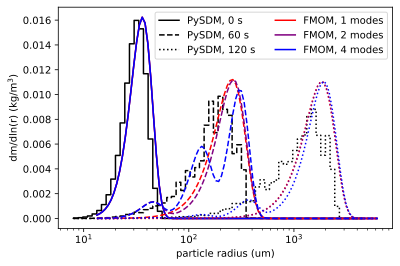

In [ ]:
fig, ax = pyplot.subplots(ncols=1, sharey=True, figsize=(6,4), dpi=200)
m_plt_ug = np.logspace(-2.0, 6.0, 100) * si.ug

r1_plt = settings_a.formulae.trivia.radius(volume=m_plt_ug / settings_a.rho)

for (j, step) in enumerate(settings_a.steps):
    line = ax.step(
        in_unit(res_a.radius_bins_left_edges, si.um),
        res_a.dv_dlnr[j] * settings_a.rho,
        label=f'PySDM, {step} s',
        linestyle = ls_list[j],
        color=c_list[-1]
    )

for (j, step) in enumerate(settings_a.steps):
    for (k, fmg) in enumerate((fm1g, fm2g, fm4g)):
        ndist = len(fmg.dist)
        dmdlnr = 0.0 * m_plt_ug
        for i in range(ndist):
            params_i = fmg['params'].sel(dist=i).where(fm1g['time']==step, drop=True).values[:,0]
            dmdlnr_i = dvdlnr_gamma(
                m_plt_ug,
                *params_i
            ) * 3 * m_plt_ug**2 / si.m**3
            dmdlnr += dmdlnr_i
        ax.plot(
            in_unit(r1_plt, si.um),
            in_unit(dmdlnr, si.kg / si.m**3),
            label=f'FMOM, {ndist} modes' if j==0 else '_',
            linestyle = ls_list[j],
            color=c_list[k]
        )

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dln(r) (kg/m$^3$)")
ax.legend(ncol=2)
show_plot('../figures/fig4/fig4_spectra.pdf')

In [9]:
settings_aMom = Settings0D(
    kernel = Golovin(b=5e3 * si.s),
    steps = np.linspace(0, 120, 13, dtype=int)
)
res_aMom = run_box(settings_aMom)

/Users/dejong5/Documents/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


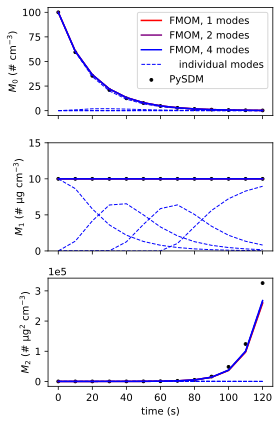

In [30]:
fig, ax = pyplot.subplots(nrows=3, sharex=True, figsize=(4,6), dpi=200, tight_layout=True)
for i in range(3):
    for (k, fmg) in enumerate((fm1g, fm2g, fm4g)):
        ndist = len(fmg.dist)
        ax[i].plot(
            fmg['time'],
            in_unit(fmg['moments'].isel(order=i).sum('dist'), si.ug**i / si.cm**3),
            label=f'FMOM, {ndist} modes',
            color=c_list[k]
        )
        if ndist == 4:
            for j in range(ndist):
                ax[i].plot(
                fmg['time'],
                in_unit(fmg['moments'].isel(order=i, dist=j), si.ug**i / si.cm**3),
                label=f'   individual modes' if j==0 else "_",
                color=c_list[k],
                linestyle='--',
                linewidth=1
            )

    ax[i].scatter(
        np.asarray(settings_aMom.steps) * settings_aMom.dt,
        in_unit(
            res_aMom.moments[:, i] * settings_aMom.dv * settings_aMom.rho**i,
            si.ug**i / si.cm**3
        ),
        marker='o', s=8, color=c_list[-1], linestyle='None', label='PySDM'
    )
ax[0].legend()
ax[0].set_ylabel('$M_0$ (# cm$^{-3}$)')
ax[1].set_ylabel('$M_1$ (# µg cm$^{-3}$)')
ax[1].set_ylim([0.0, 15.0])
ax[2].set_ylabel('$M_2$ (# µg$^2$ cm$^{-3}$)')
ax[2].set_xlabel('time (s)')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,2))

show_plot('../figures/fig4/fig4_moments.pdf')

# Fig 5: Geometric

In [39]:
# convert the constant to volumetric units instead of mass units
coll_const = 1e2 * np.pi * si.m**3 * si.kg**(-4/3) / si.s
coll_const = coll_const * (1000 * si.kg / si.m**3)**(4/3)
settings_b = Settings0D(
    kernel = SimpleGeometric(C=coll_const),
    steps = [0, 240],
    radius_bins_edges = np.logspace(
        np.log10(8.0 * si.um), np.log10(5000 * si.um), num=64, endpoint=True
    ),
    n_sd = 2**17,
)
res_b = run_box(settings_b)

/Users/dejong5/Documents/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
/var/folders/p0/4_dx18lx2hg2t2d47ltv2r8m00223t/T/ipykernel_15928/659339647.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mom[i, 0] = particulator.products["M0"].get()
/var/folders/p0/4_dx18lx2hg2t2d47ltv2r8m00223t/T/ipykernel_15928/659339647.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mom[i, 1] = particulator.products["M1"].get()
/var/folders/p0/4_dx18lx2hg2t2d47ltv2r8m00223t/T/ipykernel_15928/659339647.py:53: DeprecationWarning: Conversion of an array with ndim > 0 t

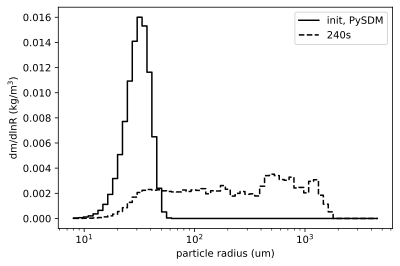

In [43]:
fig, ax = pyplot.subplots(ncols=1, sharey=True, figsize=(6,4), dpi=200)

m_plt_ug = np.logspace(-3.0, 3.0, 100)

r2_plt = settings_b.formulae.trivia.radius(volume=m_plt_ug * si.ug / settings_b.rho)

for (j, step) in enumerate(settings_b.steps):
    line = ax.step(
        in_unit(res_b.radius_bins_left_edges, si.um),
        res_b.dv_dlnr[j] * settings_b.rho,
        label='init, PySDM' if j==0 else (str(step) + 's'),
        color = c_list[-1],
        linestyle = ls_list[j]
    )
    
    # a2_dmdlnr = dvdlnr_gamma(
    #     m_plt_ug,
    #     cloudy_data_0d.MOM_data['Geometric']['aDists'][j][0],
    #     cloudy_data_0d.MOM_data['Geometric']['aDists'][j][1],
    #     cloudy_data_0d.MOM_data['Geometric']['aDists'][j][2]
    # ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    # ax.plot(
    #     in_unit(r2_plt, si.um),
    #     in_unit(a2_dmdlnr, si.kg/si.m**3),
    #     '--',
    #     label='Cloudy.jl, 1 mode' if j==0 else '_',
    #     color=line[-1].get_color()
    # )

    # b2_dmdlnr = dvdlnr_gamma(
    #     m_plt_ug,
    #     cloudy_data_0d.MOM_data['Geometric']['bDists1'][j][0],
    #     cloudy_data_0d.MOM_data['Geometric']['bDists1'][j][1],
    #     cloudy_data_0d.MOM_data['Geometric']['bDists1'][j][2]
    # ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    # b2_dmdlnr += dvdlnr_gamma(
    #     m_plt_ug,
    #     cloudy_data_0d.MOM_data['Geometric']['bDists2'][j][0],
    #     cloudy_data_0d.MOM_data['Geometric']['bDists2'][j][1],
    #     cloudy_data_0d.MOM_data['Geometric']['bDists2'][j][2]
    # ) * 3 * m_plt_ug**2 * si.ug / si.cm**3
    # ax.plot(
    #     in_unit(r2_plt, si.um),
    #     in_unit(b2_dmdlnr, si.kg/si.m**3),
    #     '.-',
    #     label='Cloudy.jl, 2 modes' if j==0 else '_',
    #     color=line[-1].get_color()
    # )

ax.set_xscale("log")
ax.set_xlabel("particle radius (um)")
ax.set_ylabel("dm/dlnR (kg/m$^3$)")
ax.legend()
show_plot('box2.pdf')

In [9]:
settings_c = Settings0D(
    kernel = settings_b.kernel,
    steps = np.linspace(0, 240, 41, dtype=int),
    radius_bins_edges = settings_b.radius_bins_edges,
)
res_c = run_box(settings_c)

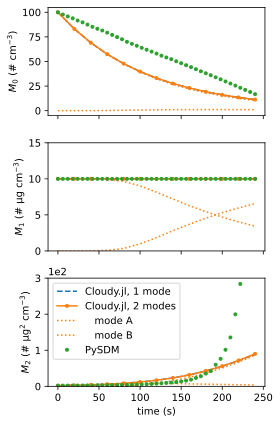

HTML(value="<a href='./box2_moments.pdf' target='_blank'>./box2_moments.pdf</a><br>")

In [15]:
fig, ax = pyplot.subplots(nrows=3, sharex=True, figsize=(4,6), dpi=200, tight_layout=True)
for i in range(3):
    line = ax[i].plot(
        cloudy_data_0d.MOM_data['Geometric']['t'],
        cloudy_data_0d.MOM_data['Geometric']['aMoments'][i],
        '--', label='Cloudy.jl, 1 mode'
    )
    line = ax[i].plot(
        cloudy_data_0d.MOM_data['Geometric']['t'],
        cloudy_data_0d.MOM_data['Geometric']['bMoments'][i, 0]
        + cloudy_data_0d.MOM_data['Geometric']['bMoments'][i, 1],
        '.-', label='Cloudy.jl, 2 modes'
    )
    ax[i].plot(
        cloudy_data_0d.MOM_data['Geometric']['t'],
        cloudy_data_0d.MOM_data['Geometric']['bMoments'][i,0],
        ':',
        linewidth=1.5, label='   mode A', color=line[-1].get_color()
    )
    ax[i].plot(
        cloudy_data_0d.MOM_data['Geometric']['t'],
        cloudy_data_0d.MOM_data['Geometric']['bMoments'][i, 1],
        ':',
        linewidth=1.5, label='   mode B', color=line[-1].get_color()
    )
    ax[i].plot(
        np.asarray(settings_c.steps) * settings_c.dt,
        in_unit(
            res_c.moments[:, i] * settings_c.dv * settings_c.rho**i,
            si.ug**i / si.cm**3
        ),
        marker='.',
        linestyle='None',
        label='PySDM'
    )

ax[2].legend()
ax[0].set_ylabel('$M_0$ (# cm$^{-3}$)')
ax[1].set_ylabel('$M_1$ (# µg cm$^{-3}$)')
ax[1].set_ylim([0.0, 15.0])
ax[2].set_ylim([0.0, 3e2])
ax[2].set_ylabel('$M_2$ (# µg$^2$ cm$^{-3}$)')
ax[2].set_xlabel('time (s)')
ax[2].ticklabel_format(axis='y', style='sci', scilimits=(0,2))

show_plot('box2_moments.pdf')